# Introducción y limpieza de datos

In [1]:
# Manejo de datos
import pandas as pd                 # Análisis y manipulación de datos en tablas
import numpy as np                  # Cálculos numéricos y matrices
import os                           # Gestión de rutas de archivos

# Visualización de datos
import matplotlib.pyplot as plt     # Gráficos básicos en 2D
import seaborn as sns               # Gráficos estadísticos mejorados
import plotly.express as px         # Gráficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gráficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly

# Procesado y análisis
from scipy import stats
from scipy.stats import chi2_contingency, norm, ttest_ind, f_oneway # Pruebas de hipótesis y análisis estadístico
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report,roc_auc_score, confusion_matrix,roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ruta = '/content/drive/MyDrive/Grupo4/Trabajo'


if os.path.exists(ruta):
    print(f"Contenido de {ruta}:\n")
    archivos = os.listdir(ruta)
    for archivo in archivos:
        print(" -", archivo)
else:
    print(f"❌ La ruta no existe:\n{ruta}")

Contenido de /content/drive/MyDrive/Grupo4/Trabajo:

 - df_disease_gene.csv
 - df_diseases.csv
 - df_genes.csv
 - df_rd_classification.csv
 - df_rd_epidemiology.csv
 - df_rd_functional_consequences.csv
 - df_rd_history.csv
 - df_rd_list.csv
 - df_rd_phenotypes.csv


In [4]:
orphadata = {}

for archivo in os.listdir(ruta):
    if archivo.endswith('.csv'):
        # Eliminar 'df_' i 'rd_' del nombre del archivo
        nombre_limpio = archivo.replace('.csv', '').replace('df_', '').replace('rd_', '')
        nombre_clave = nombre_limpio.lower().replace(' ', '_')
        ruta_completa = os.path.join(ruta, archivo)

        try:
            df = pd.read_csv(ruta_completa)
            orphadata[nombre_clave] = df
            print(f"✅ Cargado: {nombre_clave} ({df.shape[0]} filas, {df.shape[1]} columnas)")
        except Exception as e:
            print(f"❌ Error al cargar {archivo}: {e}")

✅ Cargado: disease_gene (8193 filas, 9 columnas)
✅ Cargado: diseases (27613 filas, 3 columnas)
✅ Cargado: genes (4478 filas, 3 columnas)
✅ Cargado: classification (35 filas, 2 columnas)
✅ Cargado: epidemiology (16119 filas, 10 columnas)
✅ Cargado: functional_consequences (1046 filas, 3 columnas)
✅ Cargado: history (6994 filas, 9 columnas)
✅ Cargado: list (11074 filas, 2 columnas)
✅ Cargado: phenotypes (114961 filas, 5 columnas)


In [5]:
# ✅ En diseases → renombrar 'class_hchId' a 'hchId'
orphadata['diseases'].rename(columns={'class_hchId': 'hchId'}, inplace=True)

# ✅ En epidemiology → renombrar 'Code Disease' a 'ORPHAcode'
orphadata['epidemiology'].rename(columns={'Code Disease': 'ORPHAcode'}, inplace=True)

# ✅ En disease_gene → renombrar 'name' a 'Gene name' y 'symbol' a 'Gene symbol'
orphadata['disease_gene'].rename(columns={
    'name': 'Gene name',
    'symbol': 'Gene symbol'
}, inplace=True)

# ✅ En functional_consequences → renombrar 'Código Orphanet' y 'Nombre'
orphadata['functional_consequences'].rename(columns={
    'Código Orphanet': 'ORPHAcode',
    'Nombre': 'disease_name'
}, inplace=True)

Limpiar columnas sin interés

In [6]:
orphadata['functional_consequences'] = orphadata['functional_consequences'].drop(columns=['Consecuencias Funcionales'])
orphadata['disease_gene'] = orphadata['disease_gene'].drop(columns=['Validation source'])
orphadata['diseases'] = orphadata['diseases'].drop(columns=['hchId'])
orphadata['epidemiology'] = orphadata['epidemiology'].drop(columns=['ValMoy', 'PrevalenceValidationStatus', 'Source'])

In [7]:
# Mostra las columnas de cada tabla
for nombre, df in orphadata.items():
    print(f"\n📄 {nombre} ({df.shape[0]} files):")
    print(list(df.columns))



📄 disease_gene (8193 files):
['ORPHAcode', 'Disorder name', 'Disorder type', 'Gene symbol', 'Gene name', 'Gene type', 'Gene synonyms', 'Locus']

📄 diseases (27613 files):
['ORPHAcode', 'preferredTerm']

📄 genes (4478 files):
['HGNC', 'name', 'symbol']

📄 classification (35 files):
['hchId', 'hchTag']

📄 epidemiology (16119 files):
['ORPHAcode', 'Preferred term', 'Typology', 'PrevalenceType', 'PrevalenceClass', 'PrevalenceQualification', 'PrevalenceGeographic']

📄 functional_consequences (1046 files):
['disease_name', 'ORPHAcode']

📄 history (6994 files):
['data', 'AverageAgeOfOnset', 'Date', 'DisorderGroup', 'ORPHAcode', 'OrphanetURL', 'Preferred term', 'TypeOfInheritance', 'Typology']

📄 list (11074 files):
['ORPHAcode', 'Preferred term']

📄 phenotypes (114961 files):
['ORPHAcode', 'Disorder', 'HPO_ID', 'HPO_Term', 'Frequency']


In [8]:
# Copiar y renombrar columnas similares para diferenciarlas

lista_final = orphadata['list'].rename(columns={
    'Preferred term': 'Preferred_term_list'
})

functional_consequence_final = orphadata['functional_consequences'].rename(columns={
    'disease_name': 'Disease_name_func'
})

disease_gene_final = orphadata['disease_gene'].rename(columns={
    'Disorder name': 'Disease_name_dg'
})

phenotypes_final = orphadata['phenotypes'].rename(columns={
    'Disorder': 'Disease_name_pheno'
})

diseases_final = orphadata['diseases'].rename(columns={
    'preferredTerm': 'Preferred_term_diseases'
})

epidemiology_final = orphadata['epidemiology'].rename(columns={
    'Preferred term': 'Preferred_term_epi'
})

In [9]:
tablas_finales = {
    'list': lista_final,
    'functional_consequences': functional_consequence_final,
    'disease_gene': disease_gene_final,
    'phenotypes': phenotypes_final,
    'diseases': diseases_final,
    'epidemiology': epidemiology_final
}

In [10]:
print(tablas_finales.keys())

dict_keys(['list', 'functional_consequences', 'disease_gene', 'phenotypes', 'diseases', 'epidemiology'])


In [11]:
for nombre, df in tablas_finales.items():
    print(f"\n📄 {nombre} ({df.shape[0]} files):")
    print(list(df.columns))


📄 list (11074 files):
['ORPHAcode', 'Preferred_term_list']

📄 functional_consequences (1046 files):
['Disease_name_func', 'ORPHAcode']

📄 disease_gene (8193 files):
['ORPHAcode', 'Disease_name_dg', 'Disorder type', 'Gene symbol', 'Gene name', 'Gene type', 'Gene synonyms', 'Locus']

📄 phenotypes (114961 files):
['ORPHAcode', 'Disease_name_pheno', 'HPO_ID', 'HPO_Term', 'Frequency']

📄 diseases (27613 files):
['ORPHAcode', 'Preferred_term_diseases']

📄 epidemiology (16119 files):
['ORPHAcode', 'Preferred_term_epi', 'Typology', 'PrevalenceType', 'PrevalenceClass', 'PrevalenceQualification', 'PrevalenceGeographic']


MERGE

In [12]:
df_merged = tablas_finales['list'] \
    .merge(tablas_finales['diseases'], on='ORPHAcode', how='left') \
    .merge(tablas_finales['phenotypes'], on='ORPHAcode', how='left') \
    .merge(tablas_finales['functional_consequences'], on='ORPHAcode', how='left') \
    .merge(tablas_finales['epidemiology'], on='ORPHAcode', how='left') \
    .merge(tablas_finales['disease_gene'], on='ORPHAcode', how='left')

Merge de las columnas reiterativas

In [13]:
df_merged['Disease_name_unificado'] = df_merged[
    ['Disease_name_func', 'Disease_name_dg', 'Disease_name_pheno']
].bfill(axis=1).iloc[:, 0]

df_merged.drop(columns=['Disease_name_func', 'Disease_name_dg', 'Disease_name_pheno'], inplace=True)

/tmp/ipython-input-13-3479528273.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].bfill(axis=1).iloc[:, 0]


In [14]:
df_merged['Preferred_term_unificado'] = df_merged[
    ['Preferred_term_list', 'Preferred_term_diseases', 'Preferred_term_epi']
].bfill(axis=1).iloc[:, 0]

df_merged.drop(columns=['Preferred_term_list', 'Preferred_term_diseases', 'Preferred_term_epi'], inplace=True)

In [15]:
df_merged['Disorder_type_unificado'] = df_merged[
    ['Disorder type', 'Typology']
].bfill(axis=1).iloc[:, 0]

df_merged.drop(columns=['Disorder type', 'Typology'], inplace=True)

/tmp/ipython-input-15-2913094727.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ].bfill(axis=1).iloc[:, 0]


In [16]:
print(df_merged.columns)

Index(['ORPHAcode', 'HPO_ID', 'HPO_Term', 'Frequency', 'PrevalenceType',
       'PrevalenceClass', 'PrevalenceQualification', 'PrevalenceGeographic',
       'Gene symbol', 'Gene name', 'Gene type', 'Gene synonyms', 'Locus',
       'Disease_name_unificado', 'Preferred_term_unificado',
       'Disorder_type_unificado'],
      dtype='object')


In [17]:
df_merged.head()

,ORPHAcode,HPO_ID,HPO_Term,Frequency,PrevalenceType,PrevalenceClass,PrevalenceQualification,PrevalenceGeographic,Gene symbol,Gene name,Gene type,Gene synonyms,Locus,Disease_name_unificado,Preferred_term_unificado,Disorder_type_unificado
0,166024,HP:0000207,Triangular mouth,Very frequent (99-80%),Cases/families,NaN,Case(s),Worldwide,KIF7,kinesin family member 7,gene with protein product,['JBTS12'],"[{'GeneLocus': '15q26.1', 'LocusKey': 1}]",Multiple epiphyseal dysplasia-macrocephaly-fac...,Multiple epiphyseal dysplasia-macrocephaly-fac...,Disease
1,166024,HP:0000207,Triangular mouth,Very frequent (99-80%),Point prevalence,<1 / 1 000 000,Class only,Worldwide,KIF7,kinesin family member 7,gene with protein product,['JBTS12'],"[{'GeneLocus': '15q26.1', 'LocusKey': 1}]",Multiple epiphyseal dysplasia-macrocephaly-fac...,Multiple epiphyseal dysplasia-macrocephaly-fac...,Disease
2,166024,HP:0000256,Macrocephaly,Very frequent (99-80%),Cases/families,NaN,Case(s),Worldwide,KIF7,kinesin family member 7,gene with protein product,['JBTS12'],"[{'GeneLocus': '15q26.1', 'LocusKey': 1}]",Multiple epiphyseal dysplasia-macrocephaly-fac...,Multiple epiphyseal dysplasia-macrocephaly-fac...,Disease
3,166024,HP:0000256,Macrocephaly,Very frequent (99-80%),Point prevalence,<1 / 1 000 000,Class only,Worldwide,KIF7,kinesin family member 7,gene with protein product,['JBTS12'],"[{'GeneLocus': '15q26.1', 'LocusKey': 1}]",Multiple epiphyseal dysplasia-macrocephaly-fac...,Multiple epiphyseal dysplasia-macrocephaly-fac...,Disease
4,166024,HP:0000316,Hypertelorism,Very frequent (99-80%),Cases/families,NaN,Case(s),Worldwide,KIF7,kinesin family member 7,gene with protein product,['JBTS12'],"[{'GeneLocus': '15q26.1', 'LocusKey': 1}]",Multiple epiphyseal dysplasia-macrocephaly-fac...,Multiple epiphyseal dysplasia-macrocephaly-fac...,Disease


# Clustering por K-Means

K-means es un método de clustering ampliamente utilizado para agrupar datos en función de sus características comunes sin necesidad de etiquetas previas. En nuestro caso, aplicar K-means nos permite identificar grupos homogéneos dentro de nuestro conjuntos complejos de datos fenotípicos, facilitando la detección de patrones clínicos o perfiles de síntomas que podrían no ser evidentes a simple vista. Esta técnica ayuda a simplificar y resumir la heterogeneidad biológica, lo que es fundamental para entender mejor las posibles subcategorías de una enfermedad, orientar diagnósticos más precisos y diseñar estrategias terapéuticas específicas.

Vamos a realizar el clustering utilizando las frecuencias de los términos HPO. Usamos las variables de frecuencia de HPO porque representan la prevalencia con la que cada síntoma aparece en distintas enfermedades, aportando información cuantitativa clave para diferenciar y agrupar las enfermedades según sus perfiles clínicos. Estas frecuencias cualitativas hay que convertirlas en valores numéricos porque K-means requiere variables numéricas para calcular distancias euclidianas entre los datos. Sin esta conversión, el algoritmo no podría medir similitudes ni diferencias y, por tanto, no podría formar clusters significativos. Así, la transformación de frecuencias en números permite aplicar clustering para identificar grupos de enfermedades con patrones sintomáticos similares. Esto nos permite diferenciar no solo qué síntomas están presentes, sino con qué intensidad o regularidad aparecen.

En este análisis, primero transformamos las frecuencias cualitativas de aparición de síntomas en valores numéricos basados en estimaciones representativas del rango porcentual que cada categoría abarca. Por ejemplo, para "Very frequent (99-80%)" se asigna 0.895, que es el promedio de 99% y 80%, reflejando la frecuencia media aproximada dentro de ese intervalo. Esta aproximación permite convertir categorías cualitativas en valores continuos que conservan una relación proporcional entre ellas.

In [18]:
# Transformación de las frecuencias cualitativas a valores numéricos
freq_map = {
    "Obligate (100%)": 1.00,                  # 100%
    "Very frequent (99-80%)": 0.895,          # promedio: (99+80)/2 = 89.5%
    "Frequent (79-30%)": 0.545,               # (79+30)/2 = 54.5%
    "Occasional (29-5%)": 0.17,               # (29+5)/2 = 17%
    "Rare (<4%)": 0.02,                       # asumimos 2%
    "Excluded (0%)": 0.0,
    np.nan: np.nan                            # dejamos como NaN real
}

df_merged['frequency_numeric'] = df_merged['Frequency'].map(freq_map).fillna(0)

 Ahora, organizamos los datos en una matriz donde cada fila representa una enfermedad y cada columna un síntoma, con valores numéricos de frecuencia que reflejan la presencia relativa de cada síntoma en la enfermedad.

In [19]:
# Pivotar a matriz enfermedades x síntomas
df_pivot = df_merged.pivot_table(index='ORPHAcode',
                                 columns='HPO_ID',
                                 values='frequency_numeric',
                                 aggfunc='max',
                                 fill_value=0)


Dado que esta matriz tiene una dimensionalidad muy alta, aplicamos Análisis de Componentes Principales (PCA) para reducir la dimensionalidad, manteniendo la mayor parte de la varianza explicativa. Esto facilita el posterior clustering al simplificar la estructura de los datos y reducir ruido.

In [20]:
# Reducción de dimensionalidad con PCA
pca = PCA(n_components=50)  # puedes ajustar según varianza explicada
X_pca = pca.fit_transform(df_pivot)

El método K-means requiere que se especifique de antemano el número de clusters, ya que no lo determina automáticamente. Para determinar el número óptimo de clusters, evaluamos diferentes cantidades de grupos usando el método del codo que evalúa la inercia (suma de distancias cuadráticas dentro de clusters). Visualizamos la métrica con un gráfico para identificar el punto donde añadir más clusters no mejora significativamente la agrupación.

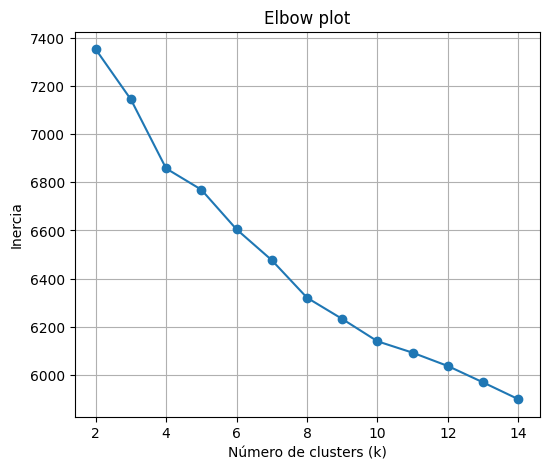

In [21]:
inertia = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

# Visualización solo del Elbow Plot
plt.figure(figsize=(6, 5))
plt.plot(K_range, inertia, marker='o')
plt.title("Elbow plot")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.grid(True)
plt.show()

En nuestro caso, aunque el método del codo no muestra una estabilización clara de la inercia, **k=7** representa un punto intermedio donde la reducción de la varianza intra-cluster comienza a ralentizarse (entre k=5 y k=9), evitando tanto la sobresimplificación (k=2, que ignora subgrupos relevantes) como la sobrepartición (k>9, que genera clusters artificiales). La elección de **k=7 clusters** se fundamenta en un equilibrio entre el análisis técnico y la interpretabilidad práctica:  Esta decisión se refuerza al considerar el contexto del estudio —clasificación de enfermedades raras—, donde **7 grupos** permiten capturar la heterogeneidad fenotípica sin perder utilidad clínica.

Aplicamos el modelo final sobre los datos reducidos con PCA y asignamos a cada enfermedad un clúster. Para facilitar la interpretación visual de la agrupación, reducimos la dimensionalidad con t-SNE y representamos los clústers en un gráfico bidimensional.

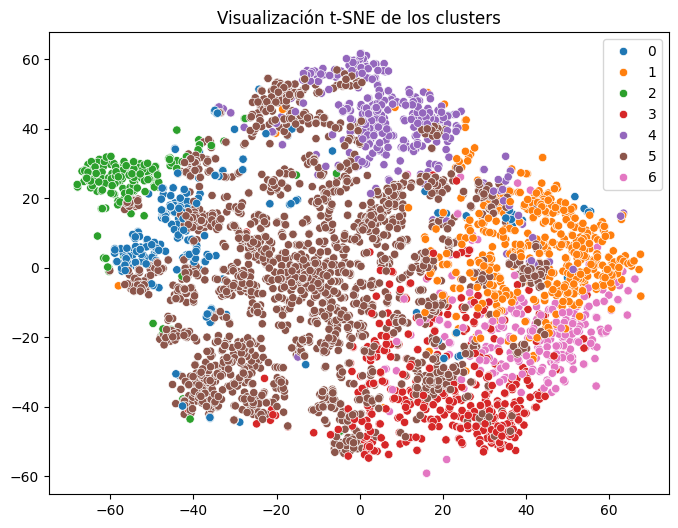

In [22]:
# Elección de k óptimo y hacer clustering final
k_opt = 7 #por ensayo y error nos quedamos con 7 clusters
kmeans_final = KMeans(n_clusters=k_opt, random_state=0)
clusters = kmeans_final.fit_predict(X_pca)

# Añadimos clusters al dataframe
df_pivot['cluster'] = clusters

# Visualizamos con t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_pca)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=clusters, palette='tab10')
plt.title("Visualización t-SNE de los clusters")
plt.show()


Más interactivo

In [23]:
# t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_pca)

# Crear DataFrame con coordenadas y metadatos
df_plot = pd.DataFrame({
    'x': X_tsne[:, 0],
    'y': X_tsne[:, 1],
    'cluster': clusters,
    'ORPHAcode': df_pivot.index
}).reset_index(drop=True)

# Gráfico interactivo
fig = px.scatter(
    df_plot,
    x='x',
    y='y',
    color='cluster',
    hover_data=['ORPHAcode'],
    title='Visualización t-SNE de los clusters'
)

# Ajustar dimensiones: 800x600 píxels
fig.update_layout(width=800, height=600)

fig.show()


Ahora asignamos a cada enfermedad el clúster correspondiente resultante del modelo K-means, añadiendo esta información como una nueva columna en la matriz (`df_pivot`). A continuación, calculamos el número de elementos en cada clúster con el objetivo de conocer la distribución de las enfermedades entre los grupos. Este análisis es útil para identificar posibles desequilibrios en la partición y valorar la coherencia del número de clústeres seleccionado.

In [24]:
kmeans_final = KMeans(n_clusters=7, random_state=0)
clusters = kmeans_final.fit_predict(X_pca)
df_pivot['cluster'] = clusters
df_pivot['cluster'].value_counts().sort_index()

,count
cluster,
0,246
1,513
2,190
3,401
4,366
5,2303
6,262


La distribución de enfermedades entre los clústeres es desigual, con un clúster mayoritario (el clúster 4) que agrupa 1684 enfermedades, mientras que otros, como el clúster 7, contienen solo 33. Esta asimetría sugiere que existen grupos de enfermedades con perfiles fenotípicos amplios y compartidos por un gran número de entidades, frente a otros clústeres que representan patrones más específicos o poco frecuentes. Esta diversidad en el tamaño de los clústeres indica que el modelo ha captado tanto agrupaciones generales como subtipos más concretos dentro del conjunto de enfermedades analizadas.

Ahora agrupamos las enfermedades según el clúster asignado y calculamos la media de las frecuencias de cada síntoma dentro de cada grupo. Esto permite identificar cuáles son las características fenotípicas más representativas de cada clúster obtieniendo los 10 síntomas con mayor frecuencia media en el clúster, lo que facilita la interpretación clínica o biológica del grupo y ayuda a entender qué rasgos definen ese conjunto particular de enfermedades para ver si tiene sentido.

In [25]:
# Seleccionem només les columnes HPO
hpo_cols = [col for col in df_pivot.columns if col.startswith("HP:")]

# Calculem els perfils mitjans per clúster només amb les columnes HPO
cluster_profiles = df_pivot.groupby("cluster")[hpo_cols].mean()

# Funció per obtenir els top HPO d'un clúster amb noms
def get_top_hpo_terms(cluster_id, top_n=10):
    top_hpos = (
        cluster_profiles.loc[cluster_id]
        .sort_values(ascending=False)
        .head(top_n)
        .reset_index()
        .rename(columns={"index": "HPO_ID", cluster_id: "freq"})
    )

    # Eliminar duplicats i unir amb termes HPO
    hpo_terms = df_merged[["HPO_ID", "HPO_Term"]].drop_duplicates()
    top_hpos = top_hpos.merge(hpo_terms, on="HPO_ID", how="left")
    return top_hpos.sort_values("freq", ascending=False)


In [26]:
for cluster_id in range(7):
    top_hpo = get_top_hpo_terms(cluster_id)
    print(f"\nTop HPO terms para el clúster {cluster_id}:")
    print(top_hpo)


Top HPO terms para el clúster 0:
       HPO_ID      freq                       HPO_Term
0  HP:0002240  0.337724                   Hepatomegaly
1  HP:0001508  0.194695              Failure to thrive
2  HP:0002027  0.172927                 Abdominal pain
3  HP:0002014  0.167500                       Diarrhea
4  HP:0001744  0.165467                   Splenomegaly
5  HP:0001824  0.161809                    Weight loss
6  HP:0012378  0.154837                        Fatigue
7  HP:0002910  0.137724  Elevated hepatic transaminase
8  HP:0002013  0.125711                       Vomiting
9  HP:0001510  0.122073                   Growth delay

Top HPO terms para el clúster 1:
       HPO_ID      freq                                 HPO_Term
0  HP:0001263  0.550789               Global developmental delay
1  HP:0001249  0.416735                  Intellectual disability
2  HP:0001250  0.391365                                  Seizure
3  HP:0001252  0.232778                                Hypotonia
4 

Clúster 0:
Pacientes con manifestaciones sistémicas generales como fiebre, fatiga, dolor articular y abdominal, mialgia y pérdida de peso. Posiblemente asociado a condiciones inflamatorias o infecciosas.

Clúster 1:
Perfil clínico mixto con afectación neurológica leve (convulsiones, discapacidad intelectual), problemas metabólicos (fracaso de crecimiento) y síntomas sistémicos como hipertensión y hepatomegalia. Puede representar casos con comorbilidades diversas.

Clúster 2:
Cuadro dominado por retraso del crecimiento (baja estatura, microcefalia, retraso óseo), con afectación neurológica leve. Indicativo de trastornos del desarrollo con compromiso somático importante.

Clúster 3:
Trastornos del desarrollo neurológico con discapacidad intelectual severa, hipotonía, rasgos craneofaciales dismórficos y anomalías genitales. Sugiere síndromes genéticos neurodismórficos.

Clúster 4:
Predominio de retraso global del desarrollo con epilepsia, hipotonía, dificultades alimentarias y anomalías craneofaciales. Compatible con encefalopatías del desarrollo.

Clúster 5:
Afectación predominantemente motora con disartria, ataxia, espasticidad y trastornos de la marcha. Cuadro sugerente de trastornos neuromotores como ataxias hereditarias o parálisis cerebral.

Clúster 6:
Presencia destacada de rasgos craneofaciales dismórficos (hipertelorismo, micrognatia, puente nasal deprimido), indicando síndromes genéticos con marcada dismorfología facial.

Los clústers evidencian una segmentación con sentido clínico claro: inflamatorio-sistémico (0), mixto neurológico-metabólico (1), retraso del crecimiento y afectación somática (2), neurodesarrollo con dismorfismo y discapacidad intelectual severa (3), encefalopatías del desarrollo (4), trastornos neuromotores (5) y síndromes genéticos con dismorfología facial (6). Esto indica que el modelo ha captado patrones fenotípicos relevantes, y que la separación no es arbitraria sino basada en correlaciones médicas reconocibles.

# Widget

He asignado una pequeña descripción a cada cluster para que cuando busquemos una enfermedad veamos si tiene lógica su clasificación

In [27]:
import ipywidgets as widgets
from IPython.display import display

# Descripcions curtes dels clusters
cluster_descriptions = {
    0: "Manifestaciones sistémicas inflamatorias e infecciosas.",
    1: "Perfil mixto con afectación neurológica leve y comorbilidades metabólicas.",
    2: "Retraso del crecimiento con compromiso somático y neurológico leve.",
    3: "Discapacidad intelectual severa con dismorfismo y anomalías genéticas.",
    4: "Retraso global del desarrollo con epilepsia y dificultades alimentarias.",
    5: "Trastornos neuromotores con alteraciones de la marcha y el tono muscular.",
    6: "Síndromes genéticos con dismorfología craneofacial marcada."
}

df_pivot = df_pivot.reset_index()
codigo_input = widgets.Text(
    value='',
    placeholder='Introduce un ORPHAcode',
    description='ORPHAcode:',
    layout=widgets.Layout(width='60%')
)

output = widgets.Output()

def mostrar_cluster(change):
    with output:
        output.clear_output()
        try:
            code = int(change['new'])
        except ValueError:
            print("Tienes que introducir un número válido.")
            return

        # Buscar cluster asociado
        fila_cluster = df_pivot[df_pivot['ORPHAcode'] == code]
        if fila_cluster.empty:
            print(f"ORPHAcode {code} no asignado a ningún cluster.")
            return
        cluster = fila_cluster['cluster'].values[0]

        # Buscar nombre de la enfermedad
        fila_malaltia = df_merged[df_merged['ORPHAcode'] == code]
        nom = fila_malaltia['Preferred_term_unificado'].dropna().unique()
        nom = nom[0] if len(nom) > 0 else "Desconocido"

        print(f"ORPHAcode: {code}")
        print(f"Enfermedad: {nom}")
        print(f"Cluster asignado: {cluster}")
        print(f"Descripción del cluster: {cluster_descriptions.get(cluster, 'Descripción no disponible.')}")

codigo_input.observe(mostrar_cluster, names='value')

display(codigo_input, output)


Text(value='', description='ORPHAcode:', layout=Layout(width='60%'), placeholder='Introduce un ORPHAcode')

Output()